# Unsupervised Learning and Dimensionality Reduction Experiment
### Project Overview
This project aims to explore the performance of various unsupervised learning algorithms combined with different dimensionality reduction techniques. The goal is to evaluate which combination yields the best clustering results on a high-dimensional dataset. The project leverages the SuperUnsupervisedExperimentator class to systematically test different combinations, record their performance, and visualize the results.

### Objectives
Test different combinations of dimensionality reduction and unsupervised learning algorithms.
Track execution time and performance metrics (e.g., Silhouette score) for each combination.
Visualize results in 3D scatter plots for easy comparison.
### Dataset
For this project, a simulated dataset is used, generated using make_blobs from the scikit-learn library. The dataset consists of 10,000 samples with 50 features. This synthetic dataset is ideal for testing the clustering performance of various algorithms in a controlled environment.

### 1. Import Libraries

In [4]:
import time
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import umap

### 2. Define the SuperUnsupervisedExperimentator Class


In [5]:
class SuperUnsupervisedExperimentator:
    def __init__(self, data, params):
        self.data = data
        self.params = params
        self.results = []
        self.times = []

    def naive_random(self):
        """
        Randomly select 3 features from the data.
        """
        np.random.seed(42)
        random_indices = np.random.choice(self.data.shape[1], 3, replace=False)
        return self.data[:, random_indices]

    def naive_top(self):
        """
        Select the top 3 features based on the highest variance.
        """
        variances = np.var(self.data, axis=0)
        top_indices = np.argsort(variances)[-3:]
        return self.data[:, top_indices]

    def run_experiment(self, selected_combinations=None):
        """
        Run the experiment across all or selected DR and UL combinations.
        If selected_combinations is provided, it will run only those.
        """
        combinations = selected_combinations if selected_combinations else [
            (dr_name, ul_name) 
            for dr_name in self.params['DR'] 
            for ul_name in self.params['UL']
        ]

        for dr_name, ul_name in combinations:
            dr_algo_instance = eval(self.params['DR'][dr_name])
            if isinstance(dr_algo_instance, np.ndarray):  # Check if it's a Naive method
                X_reduced = dr_algo_instance
            else:
                X_reduced = dr_algo_instance.fit_transform(self.data)

            ul_algo_instance = eval(self.params['UL'][ul_name])

            start_time = time.time()
            labels = ul_algo_instance.fit_predict(X_reduced)
            end_time = time.time()

            # Try to compute silhouette score, handle the error if it fails
            try:
                silhouette = silhouette_score(X_reduced, labels)
            except ValueError:
                silhouette = np.nan  # Assign NaN if silhouette score cannot be computed

            elapsed_time = end_time - start_time

            # Store the results
            self.results.append({
                'DR': dr_name,
                'UL': ul_name,
                'Silhouette Score': silhouette,
                'Labels': labels,
                'X_reduced': X_reduced
            })

            self.times.append({
                'DR': dr_name,
                'UL': ul_name,
                'Time (seconds)': elapsed_time
            })

            # Plot the visualization
            self.visualize(dr_name, ul_name, X_reduced, labels, silhouette)

    def summary_metrics(self):
        """
        Returns a summary DataFrame of the Silhouette Scores for each combination.
        """
        return pd.DataFrame(self.results).drop(columns=['Labels', 'X_reduced'])

    def summary_times(self):
        """
        Returns a summary DataFrame of the times taken for each combination.
        """
        return pd.DataFrame(self.times)

    def visualize(self, dr_name, ul_name, X_reduced, labels, silhouette):
        """
        Visualizes the results using 3D scatter plots.
        """
        fig = px.scatter_3d(
            x=X_reduced[:, 0],
            y=X_reduced[:, 1],
            z=X_reduced[:, 2],
            color=labels.astype(str),
            title=f"{dr_name} x {ul_name} - Silhouette: {silhouette:.2f}" if not np.isnan(silhouette) else f"{dr_name} x {ul_name} - Silhouette: N/A",
            labels={'color': 'Cluster'},
            width=800,
            height=600
        )
        fig.show()

### 3. Generate Synthetic Data


In [6]:
from sklearn.datasets import make_blobs

# Generate synthetic data
X, _ = make_blobs(n_samples=10000, n_features=50, centers=5, cluster_std=1.0, random_state=42)

### 4. Define the Parameters

In [7]:
# Define the parameters
params = {
    "UL": {
        "KMEANS_5": "KMeans(n_clusters=5)",
        "KMEANS_7": "KMeans(n_clusters=7)",
        "DBSCAN_0.15": "DBSCAN(eps=0.15)",
        "GMM_5": "GaussianMixture(n_components=5)"
    },
    "DR": {
        "PCA": "PCA(n_components=3)",
        "MDS": "MDS(n_components=3)",
        "tSNE": "TSNE(n_components=3)",
        "UMAP": "umap.UMAP(n_components=3)",
        "NaiveRandom": "self.naive_random()",
        "NaiveTop": "self.naive_top()"
    }
}

### 5. Initialize and Run the Experiment


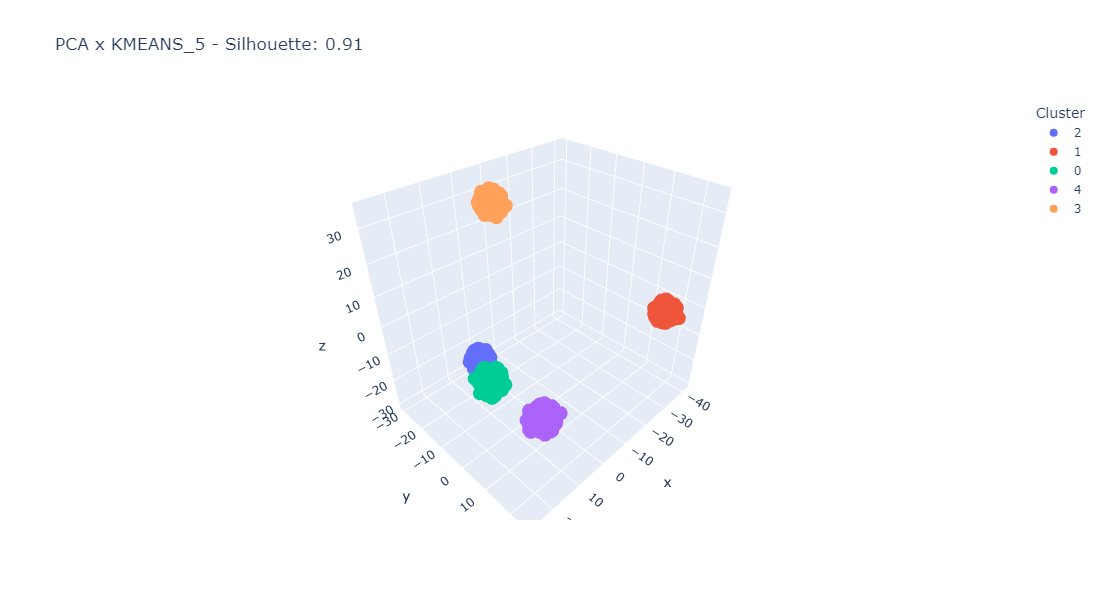

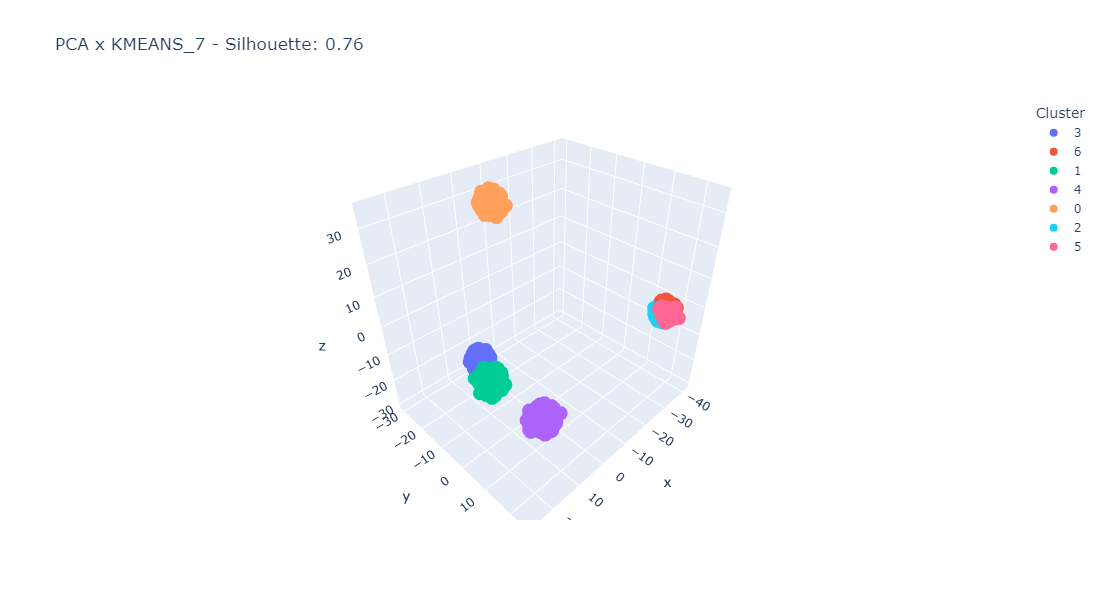

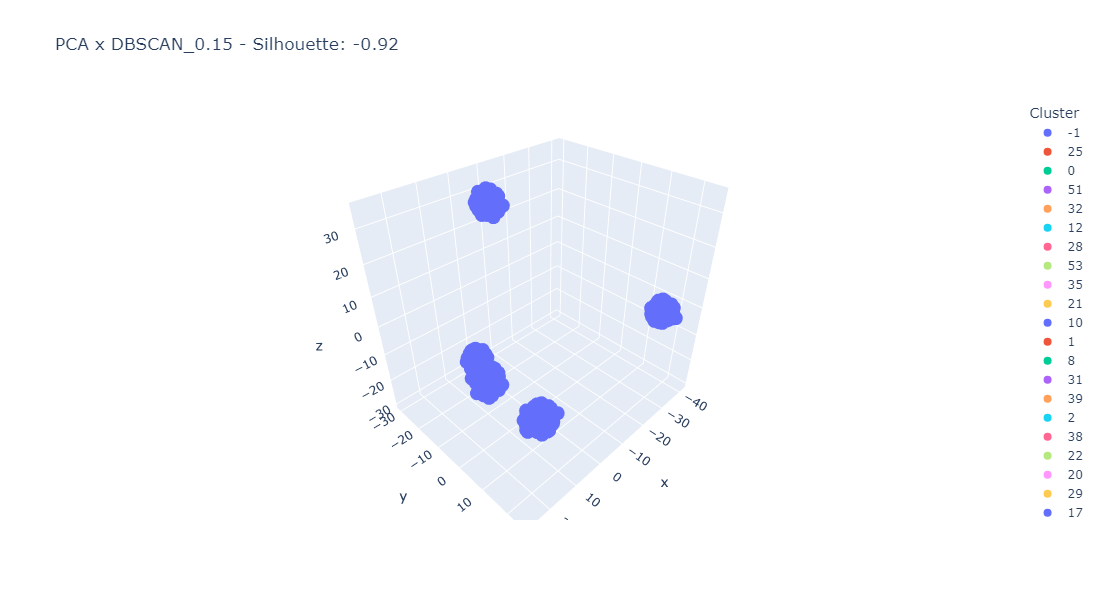

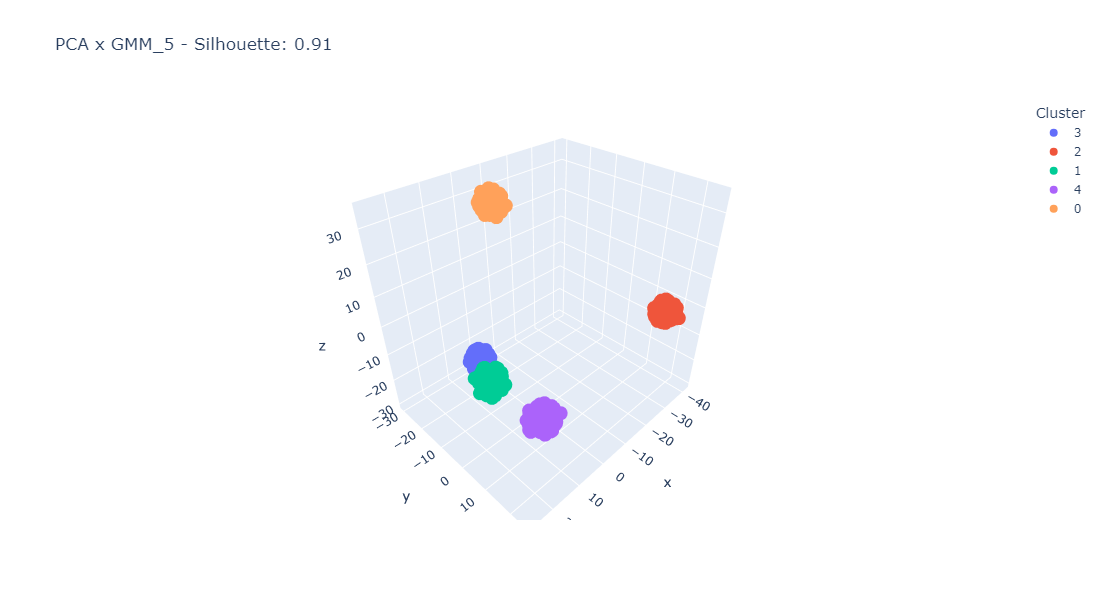

In [ ]:
# Initialize the experimentator with data and parameters
experimentator = SuperUnsupervisedExperimentator(X, params)

# Run the full experiment
experimentator.run_experiment()


### 6. Print Summary Metrics


In [9]:
# Print the summary of silhouette scores for each DR x UL combination
print("Summary of Silhouette Scores:")
print(experimentator.summary_metrics())

Summary of Silhouette Scores:
    DR           UL  Silhouette Score
0  PCA     KMEANS_5          0.912795
1  PCA     KMEANS_7          0.657517
2  PCA  DBSCAN_0.15         -0.917243
3  PCA        GMM_5          0.912795


### 7. Print Summary Times


In [10]:
# Print the summary of times for each DR x UL combination
print("\nSummary of Evaluation Times:")
print(experimentator.summary_times())



Summary of Evaluation Times:
    DR           UL  Time (seconds)
0  PCA     KMEANS_5        0.219839
1  PCA     KMEANS_7        0.017585
2  PCA  DBSCAN_0.15        0.226015
3  PCA        GMM_5        1.329083


### 8. Run Selected Interactions


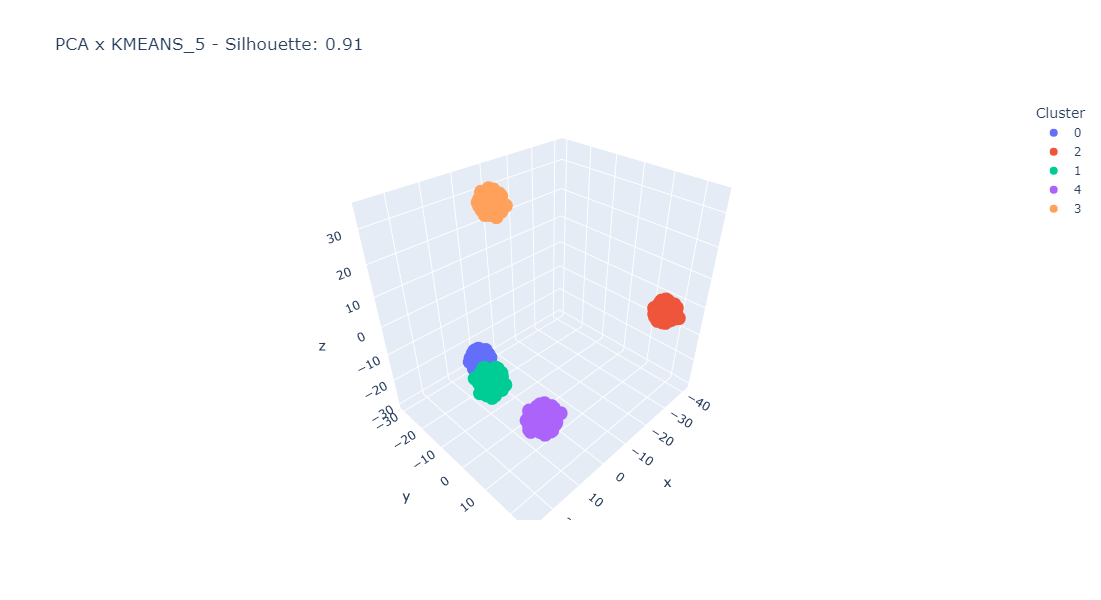

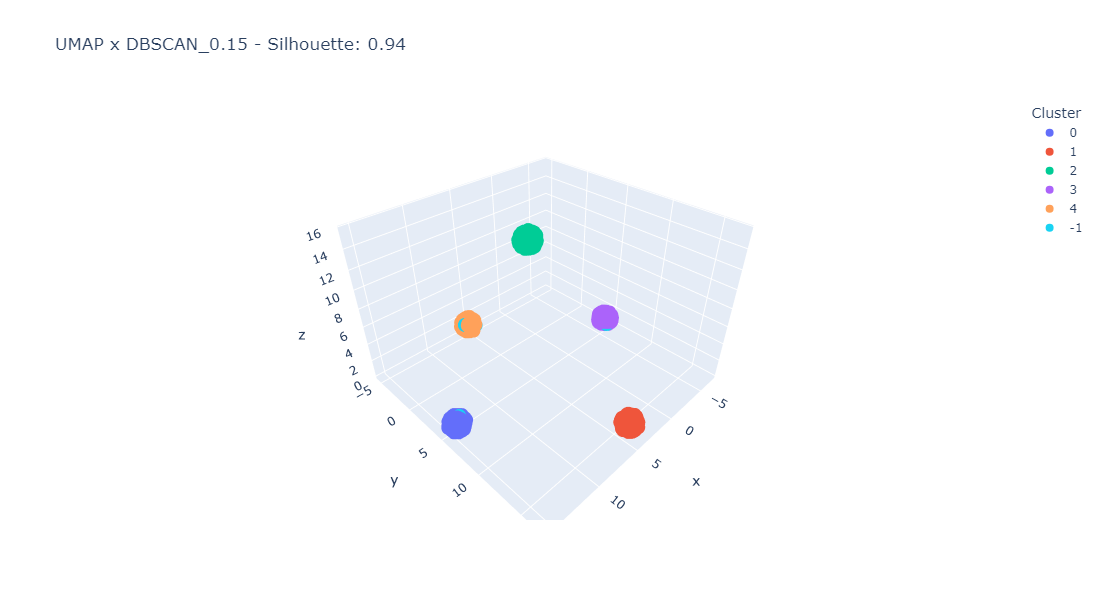

In [11]:
# Example: Run only selected interactions
selected_combinations = [
    ("PCA", "KMEANS_5"),
    ("UMAP", "DBSCAN_0.15")
]
experimentator.run_experiment(selected_combinations)


### 9. Print Updated Summary Metrics


In [12]:
# Print the updated summary of silhouette scores for each DR x UL combination
print("\nUpdated Summary of Silhouette Scores (Including Selected Interactions):")
print(experimentator.summary_metrics())


Updated Summary of Silhouette Scores (Including Selected Interactions):
     DR           UL  Silhouette Score
0   PCA     KMEANS_5          0.912795
1   PCA     KMEANS_7          0.657517
2   PCA  DBSCAN_0.15         -0.917243
3   PCA        GMM_5          0.912795
4   PCA     KMEANS_5          0.912795
5  UMAP  DBSCAN_0.15          0.939618


### 10. Print Updated Summary Times


In [13]:
# Print the updated summary of times for each DR x UL combination
print("\nUpdated Summary of Evaluation Times (Including Selected Interactions):")
print(experimentator.summary_times())


Updated Summary of Evaluation Times (Including Selected Interactions):
     DR           UL  Time (seconds)
0   PCA     KMEANS_5        0.219839
1   PCA     KMEANS_7        0.017585
2   PCA  DBSCAN_0.15        0.226015
3   PCA        GMM_5        1.329083
4   PCA     KMEANS_5        0.011862
5  UMAP  DBSCAN_0.15        0.222608
